<a href="https://colab.research.google.com/github/MorganChinTang/Flower-Recognition-Model/blob/main/FinalAssignmentTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries and Setup

In [ ]:
# Computer Vision
import torch
import torchvision
from torchvision import transforms
import cv2

# Pre-trained Models
from transformers import pipeline

# Utilities
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
import time
from collections import Counter
import subprocess

print("✓ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ All libraries imported successfully!
PyTorch version: 2.9.0+cu126
CUDA available: True


In [ ]:
# Check device and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Create project directories
dirs = ['videos', 'output', 'results']
for dir_name in dirs:
    os.makedirs(dir_name, exist_ok=True)
    print(f"✓ Created {dir_name}/")

# Load pre-trained flower classifier
print("\nLoading pre-trained model...")
model_name = "loretyan/vit-base-oxford-flowers-102"
classifier = pipeline("image-classification", model=model_name, device=0 if device.type == 'cuda' else -1)
print(f"✓ Model loaded: {model_name}")
print(f"✓ Accuracy: 99.51% on 102 flower species")

Device: cuda
✓ Created videos/
✓ Created output/
✓ Created results/

Loading pre-trained model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


✓ Model loaded: loretyan/vit-base-oxford-flowers-102
✓ Accuracy: 99.51% on 102 flower species


In [ ]:
# Install yt-dlp for YouTube download
!pip install yt-dlp -q

# Function to download YouTube video
def download_youtube_video(url, output_dir='videos'):
    """Download YouTube video"""
    os.makedirs(output_dir, exist_ok=True)

    output_template = os.path.join(output_dir, '%(title)s.%(ext)s')

    command = [
        'yt-dlp',
        '-f', 'best[ext=mp4]',
        '-o', output_template,
        url
    ]

    print(f"Downloading video from: {url}")
    result = subprocess.run(command, capture_output=True, text=True)

    if result.returncode == 0:
        video_files = [f for f in os.listdir(output_dir) if f.endswith('.mp4')]
        if video_files:
            video_path = os.path.join(output_dir, video_files[-1])
            print(f"✓ Video saved: {video_path}")
            return video_path
    else:
        print(f"Error: {result.stderr}")
        return None

# Example: Download a flower video
# Uncomment and replace with actual YouTube URL
# video_url = "https://www.youtube.com/watch?v=VIDEO_ID"
# video_path = download_youtube_video(video_url)

print("✓ YouTube downloader ready!")
print("To use: video_path = download_youtube_video('YOUR_YOUTUBE_URL')")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.7 MB/s eta 0:00:00
✓ YouTube downloader ready!
To use: video_path = download_youtube_video('YOUR_YOUTUBE_URL')


In [ ]:
# Function to classify flowers in video
def classify_video_flowers(video_path, frame_interval=30):
    """
    Process video and classify flowers in each frame
    Args:
        video_path: Path to video file
        frame_interval: Process every nth frame (30 = every 30th frame)
    """
    results = []
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    processed_count = 0

    print(f"Processing video: {video_path}")
    print(f"Frame interval: {frame_interval}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            # Convert BGR to RGB for PIL
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            from PIL import Image as PILImage
            pil_image = PILImage.fromarray(frame_rgb)

            # Classify
            predictions = classifier(pil_image)

            result = {
                'frame': frame_count,
                'flower': predictions[0]['label'],
                'confidence': predictions[0]['score'],
                'timestamp': frame_count / cap.get(cv2.CAP_PROP_FPS)
            }
            results.append(result)

            print(f"Frame {frame_count}: {result['flower']} ({result['confidence']:.2%})")
            processed_count += 1

        frame_count += 1

    cap.release()
    print(f"\n✓ Processed {processed_count} frames from {frame_count} total")
    return results

print("✓ Flower classification function ready!")

✓ Flower classification function ready!


In [ ]:
# Test the classifier with a YouTube video
print("=" * 60)
print("FLOWER RECOGNITION - YOUTUBE VIDEO PROCESSING")
print("=" * 60)

# Download a sample flower video
# Using a short public domain flower video
sample_url = "https://www.youtube.com/watch?v=ryUxrFUk6MY"  # Replace with actual flower video

print("\nStep 1: Download YouTube video")
video_path = download_youtube_video(sample_url)

if video_path:
    print("\nStep 2: Process video and classify flowers")
    results = classify_video_flowers(video_path, frame_interval=30)

    print("\n" + "=" * 60)
    print("RESULTS SUMMARY")
    print("=" * 60)

    if results:
        # Count flower types
        flower_counts = Counter([r['flower'] for r in results])
        avg_confidence = np.mean([r['confidence'] for r in results])

        print(f"\nTotal frames processed: {len(results)}")
        print(f"Unique flowers detected: {len(flower_counts)}")
        print(f"Average confidence: {avg_confidence:.2%}")
        print(f"\nFlowers detected:")
        for flower, count in flower_counts.most_common():
            print(f"  - {flower}: {count} times")
else:
    print("Failed to download video")

FLOWER RECOGNITION - YOUTUBE VIDEO PROCESSING

Step 1: Download YouTube video
✓ Video saved: videos/FLOWERS CAN DANCE!!! Amazing nature⧸ Beautiful blooming flower time lapse video.mp4

Step 2: Process video and classify flowers
Processing video: videos/FLOWERS CAN DANCE!!! Amazing nature⧸ Beautiful blooming flower time lapse video.mp4
Frame interval: 30
Frame 0: giant white arum lily (4.82%)
Frame 30: giant white arum lily (4.82%)
Frame 60: giant white arum lily (10.26%)
Frame 90: giant white arum lily (10.24%)
Frame 120: giant white arum lily (11.04%)
Frame 150: giant white arum lily (8.79%)
Frame 180: giant white arum lily (10.36%)
Frame 210: giant white arum lily (10.38%)
Frame 240: cyclamen (12.80%)
Frame 270: petunia (9.02%)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Frame 300: colt's foot (19.56%)
Frame 330: spring crocus (9.48%)
Frame 360: japanese anemone (28.39%)
Frame 390: windflower (18.53%)
Frame 420: colt's foot (12.16%)
Frame 450: windflower (13.79%)
Frame 480: windflower (7.55%)
Frame 510: windflower (7.82%)
Frame 540: windflower (17.31%)
Frame 570: windflower (93.18%)
Frame 600: windflower (29.91%)
Frame 630: windflower (90.85%)
Frame 660: windflower (81.80%)
Frame 690: windflower (89.89%)
Frame 720: windflower (94.71%)
Frame 750: pink-yellow dahlia? (26.08%)
Frame 780: black-eyed susan (10.11%)
Frame 810: black-eyed susan (10.59%)
Frame 840: black-eyed susan (8.99%)
Frame 870: pink-yellow dahlia? (20.34%)
Frame 900: pink-yellow dahlia? (16.29%)
Frame 930: pink-yellow dahlia? (17.01%)
Frame 960: pink-yellow dahlia? (18.99%)
Frame 990: japanese anemone (19.44%)
Frame 1020: japanese anemone (32.75%)
Frame 1050: japanese anemone (27.19%)
Frame 1080: japanese anemone (19.14%)
Frame 1110: windflower (96.37%)
Frame 1140: windflower (77.51%)
Fr

In [ ]:
# Install datasets library
!pip install datasets -q

from datasets import load_dataset
from PIL import Image
import io

print("Downloading Oxford Flowers training dataset...")
train_dataset = load_dataset("Multimodal-Fatima/OxfordFlowers_train")
print(f"✓ Training dataset loaded: {len(train_dataset['train'])} images")

print("\nDownloading Oxford Flowers test dataset...")
test_dataset = load_dataset("Multimodal-Fatima/OxfordFlowers_test")
print(f"✓ Test dataset loaded: {len(test_dataset['test'])} images")

# Explore dataset structure
print("\nDataset structure:")
print(f"Train columns: {train_dataset['train'].column_names}")
print(f"Sample: {train_dataset['train'][0]}")

# Create local directories for organized data
import shutil
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/test', exist_ok=True)

print("\n✓ Datasets ready for training!")

README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-388918bd0a6c51(…):   0%|          | 0.00/43.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1020 [00:00<?, ? examples/s]

✓ Training dataset loaded: 1020 images



README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/test-00000-of-00001-12de423fae9ae0e(…):   0%|          | 0.00/261M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/6149 [00:00<?, ? examples/s]

✓ Test dataset loaded: 6149 images

Dataset structure:
Train columns: ['image', 'label', 'id', 'clip_tags_ViT_L_14', 'blip_caption', 'LLM_Description_gpt3_downstream_tasks_ViT_L_14', 'clip_tags_ViT_L_14_ensemble_specific', 'LLM_Description_gpt3_downstream_tasks_visual_genome_ViT_L_14', 'clip_tags_ViT_L_14_with_openai_classes', 'clip_tags_ViT_L_14_wo_openai_classes', 'Attributes_ViT_L_14_text_davinci_003', 'Attributes_ViT_L_14_text_davinci_003_full', 'Attributes_ViT_L_14_text_davinci_003_oxfordflowers', 'clip_tags_ViT_L_14_simple_specific', 'clip_tags_ViT_B_16_simple_specific', 'clip_tags_ViT_B_16_ensemble_specific', 'clip_tags_ViT_B_32_simple_specific', 'clip_tags_ViT_B_32_ensemble_specific', 'Attributes_ViT_B_16_descriptors_text_davinci_003_full', 'Attributes_LAION_ViT_H_14_2B_descriptors_text_davinci_003_full', 'clip_tags_LAION_ViT_H_14_2B_simple_specific', 'clip_tags_LAION_ViT_H_14_2B_ensemble_specific']
Sample: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=754x50

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import vit_b_16
import torch.nn.functional as F

# Create custom dataset class
class FlowerDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image'].convert('RGB')
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Create datasets
train_flower_dataset = FlowerDataset(train_dataset['train'], transform=train_transform)
test_flower_dataset = FlowerDataset(test_dataset['test'], transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_flower_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_flower_dataset, batch_size=32, shuffle=False)

print(f"✓ Train loader: {len(train_loader)} batches")
print(f"✓ Test loader: {len(test_loader)} batches")

# Load pre-trained ViT model
print("\nLoading pre-trained Vision Transformer...")
model = vit_b_16(pretrained=True)

# Freeze all layers except final classification head
for param in model.parameters():
    param.requires_grad = False

# Get number of classes
num_classes = len(set([item['label'] for item in train_dataset['train']]))
print(f"Number of flower classes: {num_classes}")

# Replace final layer for our flower classes
model.heads.head = nn.Linear(768, num_classes)

# Move to GPU
model = model.to(device)

# Loss and optimizer (only train final layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.heads.head.parameters(), lr=0.001)

print("✓ Model ready for fine-tuning!")

# Training loop
num_epochs = 5
best_accuracy = 0

print("\n" + "="*60)
print("TRANSFER LEARNING - FINE-TUNING")
print("="*60)

for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = 100 * train_correct / train_total
    train_loss = train_loss / len(train_loader)

    # Validate
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'finetuned_flower_model.pth')
        print(f"  ✓ Best model saved!")

print("\n" + "="*60)
print(f"Fine-tuning complete! Best accuracy: {best_accuracy:.2f}%")
print("="*60)

✓ Train loader: 32 batches
✓ Test loader: 193 batches

Loading pre-trained Vision Transformer...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:03<00:00, 91.6MB/s]


Number of flower classes: 102
✓ Model ready for fine-tuning!

TRANSFER LEARNING - FINE-TUNING
Epoch [1/5]
  Train Loss: 4.1396, Train Acc: 16.37%
  Val Loss: 3.2493, Val Acc: 50.17%
  ✓ Best model saved!
Epoch [2/5]
  Train Loss: 2.4094, Train Acc: 71.27%
  Val Loss: 2.2819, Val Acc: 69.12%
  ✓ Best model saved!
Epoch [3/5]
  Train Loss: 1.4790, Train Acc: 87.25%
  Val Loss: 1.7586, Val Acc: 75.74%
  ✓ Best model saved!
Epoch [4/5]
  Train Loss: 0.9698, Train Acc: 93.43%
  Val Loss: 1.4620, Val Acc: 78.05%
  ✓ Best model saved!
Epoch [5/5]
  Train Loss: 0.6782, Train Acc: 96.18%
  Val Loss: 1.2798, Val Acc: 79.80%
  ✓ Best model saved!

Fine-tuning complete! Best accuracy: 79.80%


In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import vit_b_16

# Reload model
model = vit_b_16(pretrained=True)

# Unfreeze last 3 transformer blocks + final layer for better fine-tuning
for name, param in model.named_parameters():
    if 'encoder.layers.encoder_layer_11' in name or 'encoder.layers.encoder_layer_10' in name or 'encoder.layers.encoder_layer_9' in name or 'heads' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace final layer
model.heads.head = nn.Linear(768, 102)
model = model.to(device)

# Lower learning rate for careful fine-tuning
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

print("✓ Model ready for extended fine-tuning!")
print("Training last 3 transformer blocks + final layer")

# Extended training
num_epochs = 10
best_accuracy = 0

print("\n" + "="*60)
print("EXTENDED TRANSFER LEARNING - FINE-TUNING")
print("="*60)

for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = 100 * train_correct / train_total
    train_loss = train_loss / len(train_loader)

    # Validate
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'finetuned_flower_model_extended.pth')
        print(f"  ✓ Best model saved! (Accuracy: {val_acc:.2f}%)")

print("\n" + "="*60)
print(f"Extended fine-tuning complete! Best accuracy: {best_accuracy:.2f}%")
print("="*60)

✓ Model ready for extended fine-tuning!
Training last 3 transformer blocks + final layer

EXTENDED TRANSFER LEARNING - FINE-TUNING
Epoch [1/10]
  Train Loss: 4.1379, Train Acc: 16.08%
  Val Loss: 3.0851, Val Acc: 53.34%
  ✓ Best model saved! (Accuracy: 53.34%)
Epoch [2/10]
  Train Loss: 1.9844, Train Acc: 80.69%
  Val Loss: 1.8114, Val Acc: 80.86%
  ✓ Best model saved! (Accuracy: 80.86%)
Epoch [3/10]
  Train Loss: 0.8076, Train Acc: 96.86%
  Val Loss: 1.1866, Val Acc: 87.92%
  ✓ Best model saved! (Accuracy: 87.92%)
Epoch [4/10]
  Train Loss: 0.3162, Train Acc: 99.80%
  Val Loss: 0.9240, Val Acc: 89.17%
  ✓ Best model saved! (Accuracy: 89.17%)
Epoch [5/10]
  Train Loss: 0.1431, Train Acc: 100.00%
  Val Loss: 0.7849, Val Acc: 89.95%
  ✓ Best model saved! (Accuracy: 89.95%)
Epoch [6/10]
  Train Loss: 0.0810, Train Acc: 100.00%
  Val Loss: 0.7088, Val Acc: 90.71%
  ✓ Best model saved! (Accuracy: 90.71%)
Epoch [7/10]
  Train Loss: 0.0567, Train Acc: 100.00%
  Val Loss: 0.6601, Val Acc: 91.1

In [ ]:
# Unfreeze even more layers for deeper fine-tuning
model = vit_b_16(pretrained=True)

# Unfreeze last 6 transformer blocks + final layer
for name, param in model.named_parameters():
    if 'encoder.layers.encoder_layer' in name or 'heads' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.heads.head = nn.Linear(768, 102)
model = model.to(device)

# Even lower learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00005)

print("✓ Model ready for deeper fine-tuning!")
print("Training last 6 transformer blocks + final layer")

# Train for 15 epochs
num_epochs = 15
best_accuracy = 0

print("\n" + "="*60)
print("DEEPER TRANSFER LEARNING - FINE-TUNING")
print("="*60)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = 100 * train_correct / train_total
    train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'finetuned_flower_model_best.pth')
        print(f"  ✓ Best model saved! (Accuracy: {val_acc:.2f}%)")

print("\n" + "="*60)
print(f"Fine-tuning complete! Best accuracy: {best_accuracy:.2f}%")
print("="*60)

✓ Model ready for deeper fine-tuning!
Training last 6 transformer blocks + final layer

DEEPER TRANSFER LEARNING - FINE-TUNING
Epoch [1/15] Train Acc: 14.71% | Val Acc: 44.01%
  ✓ Best model saved! (Accuracy: 44.01%)
Epoch [2/15] Train Acc: 78.92% | Val Acc: 79.12%
  ✓ Best model saved! (Accuracy: 79.12%)
Epoch [3/15] Train Acc: 97.84% | Val Acc: 87.82%
  ✓ Best model saved! (Accuracy: 87.82%)
Epoch [4/15] Train Acc: 99.90% | Val Acc: 90.11%
  ✓ Best model saved! (Accuracy: 90.11%)
Epoch [5/15] Train Acc: 100.00% | Val Acc: 90.70%
  ✓ Best model saved! (Accuracy: 90.70%)
Epoch [6/15] Train Acc: 100.00% | Val Acc: 91.06%
  ✓ Best model saved! (Accuracy: 91.06%)
Epoch [7/15] Train Acc: 100.00% | Val Acc: 91.12%
  ✓ Best model saved! (Accuracy: 91.12%)
Epoch [8/15] Train Acc: 100.00% | Val Acc: 90.93%
Epoch [9/15] Train Acc: 100.00% | Val Acc: 91.17%
  ✓ Best model saved! (Accuracy: 91.17%)
Epoch [10/15] Train Acc: 100.00% | Val Acc: 90.91%
Epoch [11/15] Train Acc: 100.00% | Val Acc: 91.1

In [ ]:
# Load the best fine-tuned model
print("Loading best fine-tuned model (92.45% accuracy)...")
finetuned_model = vit_b_16(pretrained=False)
finetuned_model.heads.head = nn.Linear(768, 102)
finetuned_model.load_state_dict(torch.load('finetuned_flower_model_best.pth'))
finetuned_model = finetuned_model.to(device)
finetuned_model.eval()

print("✓ Fine-tuned model loaded!")

# Flower class mapping (Oxford Flowers 102)
flower_classes = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'wild geranium',
    'tiger lily', 'moon orchid', 'bird of paradise', 'monarda', 'globe thistle',
    'snapdragon', "king's spear", 'yellow iris', 'globe-flower', 'purple coneflower',
    'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire pink', 'common dandelion',
    'petunia', 'wild pansy', 'primula', 'sunflower', 'lilium',
    'windflower', 'passion flower', 'poinsettia', 'vaseygrass', 'mexican sunflower',
    'armenian broom', 'camellia', 'dahlia', 'colt\'s foot', 'daffodil',
    'sword lily', 'celosia', 'desert-rose', 'tree poppy', 'morning glory',
    'orange dahlia', 'pink-yellow dahlia', 'carnation', 'columbine', 'al\'s lummis',
    'indian blanket', 'yellow tulip', 'osteospermum', 'gaura', 'gazania',
    'coral bells', 'toad lily', 'anthurium', 'frangipani', 'river lily',
    'cricket flower', 'japanese anemone', 'camellia', 'mexican aster', 'silverbush',
    'buttercup', 'oxeye daisy', 'common grape hyacinth', 'canna lily', 'anemone',
    'ranunculus', 'garden phlox', 'love in the mist', 'clematis', 'hibiscus',
    'bougainvillea', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'cowslip',
    'spring crocus', 'bearded iris', 'winter rose', 'christmas cactus', 'orange blossom',
    'iris', 'yellow rose', 'lady\'s slipper', 'yellow monarda', 'trumpet vine',
    'blanket flower', 'mexican petunia', 'black-eyed susan', 'silene', 'lenten rose',
    'polemoniaceae', 'rose', 'thorn apple', 'morning glory', 'wild geranium'
]

# Function to classify flowers in video with fine-tuned model
def classify_video_flowers_finetuned(video_path, frame_interval=30):
    """Classify flowers using fine-tuned model (92.45% accuracy)"""
    results = []
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    processed_count = 0

    print(f"\nProcessing video with fine-tuned model: {video_path}")
    print(f"Frame interval: {frame_interval}")
    print("="*60)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            from PIL import Image as PILImage
            pil_image = PILImage.fromarray(frame_rgb)

            # Preprocess
            image_tensor = val_transform(pil_image).unsqueeze(0).to(device)

            # Predict with fine-tuned model
            with torch.no_grad():
                outputs = finetuned_model(image_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                confidence, predicted = torch.max(probabilities, 1)

            flower_idx = predicted.item()
            confidence_score = confidence.item()
            flower_name = flower_classes[flower_idx] if flower_idx < len(flower_classes) else f"Class {flower_idx}"

            result = {
                'frame': frame_count,
                'flower_name': flower_name,
                'flower_class': flower_idx,
                'confidence': confidence_score,
                'timestamp': frame_count / cap.get(cv2.CAP_PROP_FPS)
            }
            results.append(result)

            print(f"Frame {frame_count:4d} | Time: {result['timestamp']:6.2f}s | {flower_name:30s} | Confidence: {confidence_score:.2%}")
            processed_count += 1

        frame_count += 1

    cap.release()
    print("="*60)
    print(f"✓ Processed {processed_count} frames from {frame_count} total frames")
    return results

# Test on the same video
print("\n" + "="*60)
print("TESTING FINE-TUNED MODEL ON YOUTUBE VIDEO")
print("="*60)

# Use the video from earlier (replace with your YouTube URL)
# video_path = "videos/your_video.mp4"  # Path to downloaded video
# results = classify_video_flowers_finetuned(video_path, frame_interval=30)

# If you want to download a new video:
sample_url = "https://www.youtube.com/watch?v=bfhCkXA6c9s"  # Replace with flower video URL
video_path = download_youtube_video(sample_url)

if video_path:
    results = classify_video_flowers_finetuned(video_path, frame_interval=30)

    # Summary statistics
    if results:
        print("\n" + "="*60)
        print("RESULTS SUMMARY")
        print("="*60)

        flower_counts = Counter([r['flower_name'] for r in results])
        avg_confidence = np.mean([r['confidence'] for r in results])
        max_confidence = max([r['confidence'] for r in results])
        min_confidence = min([r['confidence'] for r in results])

        print(f"\nTotal frames processed: {len(results)}")
        print(f"Unique flowers detected: {len(flower_counts)}")
        print(f"Average confidence: {avg_confidence:.2%}")
        print(f"Max confidence: {max_confidence:.2%}")
        print(f"Min confidence: {min_confidence:.2%}")

        print(f"\nFlowers detected (sorted by frequency):")
        for flower, count in flower_counts.most_common():
            confidence_for_flower = np.mean([r['confidence'] for r in results if r['flower_name'] == flower])
            print(f"  {count:2d}x {flower:30s} (avg confidence: {confidence_for_flower:.2%})")

        print("\n" + "="*60)
else:
    print("Failed to download video")

Loading best fine-tuned model (92.45% accuracy)...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ Fine-tuned model loaded!

TESTING FINE-TUNED MODEL ON YOUTUBE VIDEO
✓ Video saved: videos/FLOWERS CAN DANCE!!! Amazing nature⧸ Beautiful blooming flower time lapse video.mp4

Processing video with fine-tuned model: videos/FLOWERS CAN DANCE!!! Amazing nature⧸ Beautiful blooming flower time lapse video.mp4
Frame interval: 30
Frame    0 | Time:   0.00s | morning glory                  | Confidence: 2.29%
Frame   30 | Time:   1.20s | morning glory                  | Confidence: 2.29%
Frame   60 | Time:   2.40s | common dandelion               | Confidence: 2.37%
Frame   90 | Time:   3.60s | common dandelion               | Confidence: 2.37%
Frame  120 | Time:   4.80s | sword lily                     | Confidence: 3.11%
Frame  150 | Time:   6.00s | morning glory                  | Confidence: 2.41%
Frame  180 | Time:   7.20s | Class 96                       | Confidence: 2.95%
Frame  210 | Time:   8.40s | Class 96                       | Confidence: 2.95%
Frame  240 | Time:   9.60s | spri

In [ ]:
# CELL 10: Video Link Selection Manager
class VideoManager:
    def __init__(self):
        self.videos = {
            "video_1": {
                "name": "Flower Garden Time Lapse",
                "url": "https://www.youtube.com/watch?v=ryUXrFUk6MY",
                "description": "Beautiful blooming flowers in garden"
            },
            "video_2": {
                "name": "3 Minute Flower Documentary",
                "url": "https://www.youtube.com/watch?v=bfHCkXA6c9s",
                "description": "Long form flower recognition test"
            },
                        "video_3": {
                "name": "10 Minute Flower Documentary",
                "url": "https://www.youtube.com/watch?v=1Yf8Zo06Y-E",
                "description": "Blooming Flowers OLED Demo HDR 8K Ultra HD"
            }
        }
        self.current_video_path = None

    def add_video(self, video_id, name, url, description=""):
        """Add a new video to the list"""
        self.videos[video_id] = {
            "name": name,
            "url": url,
            "description": description
        }
        print(f"✓ Added: {name}")

    def remove_video(self, video_id):
        """Remove a video from the list"""
        if video_id in self.videos:
            del self.videos[video_id]
            print(f"✓ Removed: {video_id}")
        else:
            print(f"✗ Video {video_id} not found")

    def list_videos(self):
        """Display all available videos"""
        print("\n" + "="*70)
        print("AVAILABLE VIDEOS")
        print("="*70)
        for i, (vid_id, info) in enumerate(self.videos.items(), 1):
            print(f"\n{i}. {info['name']} ({vid_id})")
            print(f"   Description: {info['description']}")
            print(f"   URL: {info['url']}")
        print("\n" + "="*70)

    def select_video(self, video_id):
        """Select a video by ID and download it"""
        if video_id not in self.videos:
            print(f"✗ Video {video_id} not found!")
            self.list_videos()
            return None

        video_info = self.videos[video_id]
        print(f"\nSelected: {video_info['name']}")
        print(f"Downloading from: {video_info['url']}")

        # Download with unique filename based on video_id
        output_dir = 'videos'
        os.makedirs(output_dir, exist_ok=True)

        # Use video_id in filename to avoid overwrites
        output_template = os.path.join(output_dir, f'{video_id}_%(title)s.%(ext)s')

        command = [
            'yt-dlp',
            '-f', 'best[ext=mp4]',
            '-o', output_template,
            video_info['url']
        ]

        result = subprocess.run(command, capture_output=True, text=True)

        if result.returncode == 0:
            video_files = [f for f in os.listdir(output_dir) if f.startswith(video_id) and f.endswith('.mp4')]
            if video_files:
                self.current_video_path = os.path.join(output_dir, video_files[-1])
                print(f"✓ Video ready: {self.current_video_path}")
                return self.current_video_path

        print("✗ Failed to download video")
        return None

    def select_by_number(self, number):
        """Select video by number from list"""
        video_ids = list(self.videos.keys())
        if 1 <= number <= len(video_ids):
            selected_id = video_ids[number - 1]
            return self.select_video(selected_id)
        else:
            print(f"✗ Invalid number. Please choose 1-{len(video_ids)}")
            return None

    def get_current_video(self):
        """Get the currently selected video path"""
        return self.current_video_path

# Initialize Video Manager
video_manager = VideoManager()

print("✓ Video Manager initialized!")
print("\nUsage:")
print("  video_manager.list_videos()                    # Show all videos")
print("  video_manager.select_video('video_1')          # Select by ID")
print("  video_manager.select_by_number(1)              # Select by number")
print("  video_manager.add_video('video_3', 'Name', 'URL', 'Description')  # Add new video")

✓ Video Manager initialized!

Usage:
  video_manager.list_videos()                    # Show all videos
  video_manager.select_video('video_1')          # Select by ID
  video_manager.select_by_number(1)              # Select by number
  video_manager.add_video('video_3', 'Name', 'URL', 'Description')  # Add new video


In [ ]:
# CELL 11: Real-time Video Playback with Smooth Frame Updates
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time

# Load best fine-tuned model
print("Loading best fine-tuned model (92.45% accuracy)...")
finetuned_model = vit_b_16(pretrained=False)
finetuned_model.heads.head = nn.Linear(768, 102)
finetuned_model.load_state_dict(torch.load('finetuned_flower_model_best.pth'))
finetuned_model = finetuned_model.to(device)
finetuned_model.eval()

print("✓ Fine-tuned model loaded!")

# Flower class names (102 classes)
flower_classes = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea", "wild geranium",
    "tiger lily", "moon orchid", "bird of paradise", "monarda", "globe thistle",
    "snapdragon", "king's spear", "yellow iris", "globe-flower", "purple coneflower",
    "peruvian lily", "balloon flower", "giant white arum lily", "fire pink", "common dandelion",
    "petunia", "wild pansy", "primula", "sunflower", "lilium",
    "windflower", "passion flower", "poinsettia", "vaseygrass", "mexican sunflower",
    "armenian broom", "camellia", "dahlia", "colt's foot", "daffodil",
    "sword lily", "celosia", "desert-rose", "tree poppy", "morning glory",
    "orange dahlia", "pink-yellow dahlia", "carnation", "columbine", "al's lummis",
    "indian blanket", "yellow tulip", "osteospermum", "gaura", "gazania",
    "coral bells", "toad lily", "anthurium", "frangipani", "river lily",
    "cricket flower", "japanese anemone", "camellia", "mexican aster", "silverbush",
    "buttercup", "oxeye daisy", "common grape hyacinth", "canna lily", "anemone",
    "ranunculus", "garden phlox", "love in the mist", "clematis", "hibiscus",
    "bougainvillea", "ruby-lipped cattleya", "cape flower", "great masterwort", "cowslip",
    "spring crocus", "bearded iris", "winter rose", "christmas cactus", "orange blossom",
    "iris", "yellow rose", "lady's slipper", "yellow monarda", "trumpet vine",
    "blanket flower", "mexican petunia", "black-eyed susan", "silene", "lenten rose",
    "polemoniaceae", "rose", "thorn apple", "morning glory", "wild geranium",
    "geranium", "geranium", "geranium", "geranium"
]

flower_classes = flower_classes[:102]

def play_video_with_predictions(video_path, frame_interval=30, display_delay=0.05):
    """
    Play video in real-time with predictions
    Updates frame in-place without flickering

    Args:
        video_path: Path to video file
        frame_interval: Process every nth frame
        display_delay: Delay between frames (seconds)
    """
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    processed_count = 0
    all_results = []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / fps if fps > 0 else 0

    print(f"Starting video playback: {video_path}")
    print(f"Total frames: {total_frames} | Duration: {duration:.1f}s | FPS: {fps:.1f}")
    print(f"Processing every {frame_interval}th frame...")
    print("="*80)

    # Create figure once
    fig, ax = plt.subplots(figsize=(12, 8))
    display_handle = display(fig, display_id=True)

    start_time = time.time()

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % frame_interval == 0:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                from PIL import Image as PILImage
                pil_image = PILImage.fromarray(frame_rgb)

                image_tensor = val_transform(pil_image).unsqueeze(0).to(device)

                with torch.no_grad():
                    outputs = finetuned_model(image_tensor)
                    probabilities = torch.softmax(outputs, dim=1)
                    confidence, predicted = torch.max(probabilities, 1)

                flower_idx = predicted.item()
                confidence_score = confidence.item()
                flower_name = flower_classes[flower_idx] if flower_idx < len(flower_classes) else f"Class {flower_idx}"
                timestamp = frame_count / fps if fps > 0 else 0

                result = {
                    'frame': frame_count,
                    'flower_name': flower_name,
                    'confidence': confidence_score,
                    'timestamp': timestamp,
                    'image': frame_rgb
                }
                all_results.append(result)
                processed_count += 1

                # Clear previous image and draw new one on same axes
                ax.clear()
                ax.imshow(frame_rgb)

                # Add prediction overlay
                title_text = f"Frame {frame_count} | Time: {timestamp:.2f}s\n{flower_name.upper()} | Confidence: {confidence_score:.2%}"
                ax.set_title(title_text, fontsize=14, fontweight='bold', color='green')
                ax.axis('off')

                plt.tight_layout()

                # Update display
                display_handle.update(fig)
                time.sleep(display_delay)

            frame_count += 1

    except KeyboardInterrupt:
        print("\n\nPlayback stopped by user")

    cap.release()
    plt.close(fig)

    elapsed_time = time.time() - start_time

    # Display final results
    print("\n" + "="*80)
    print("PLAYBACK COMPLETE - FINAL RESULTS")
    print("="*80)
    print(f"Total frames processed: {len(all_results)}")
    print(f"Processing time: {elapsed_time:.1f}s")
    print(f"Average FPS: {len(all_results) / elapsed_time:.1f}")

    if all_results:
        flower_counts = Counter([r['flower_name'] for r in all_results])
        avg_confidence = np.mean([r['confidence'] for r in all_results])
        max_confidence = max([r['confidence'] for r in all_results])
        min_confidence = min([r['confidence'] for r in all_results])

        print(f"\nUnique flowers detected: {len(flower_counts)}")
        print(f"Average confidence: {avg_confidence:.2%}")
        print(f"Max confidence: {max_confidence:.2%}")
        print(f"Min confidence: {min_confidence:.2%}")

        print(f"\nFlowers detected (sorted by frequency):")
        print("-" * 80)
        for i, (flower, count) in enumerate(flower_counts.most_common(), 1):
            confidence_for_flower = np.mean([r['confidence'] for r in all_results if r['flower_name'] == flower])
            percentage = (count / len(all_results)) * 100
            print(f"{i:2d}. {flower:30s} | Count: {count:3d} ({percentage:5.1f}%) | Avg Confidence: {confidence_for_flower:.2%}")

        print("="*80)

    return all_results

print("✓ Real-time video player ready!")
print("\nUsage:")
print("  results = play_video_with_predictions(video_path, frame_interval=30, display_delay=0.05)")

Loading best fine-tuned model (92.45% accuracy)...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ Fine-tuned model loaded!
✓ Real-time video player ready!

Usage:
  results = play_video_with_predictions(video_path, frame_interval=30, display_delay=0.05)



Selected: 10 Minute Flower Documentary
✓ Video ready: videos/video_3_Blooming Flowers OLED Demo HDR 8K Ultra HD Dolby Vision™ 60fps.mp4
Starting video playback: videos/video_3_Blooming Flowers OLED Demo HDR 8K Ultra HD Dolby Vision™ 60fps.mp4
Total frames: 36312 | Duration: 605.2s | FPS: 60.0
Processing every 5th frame...


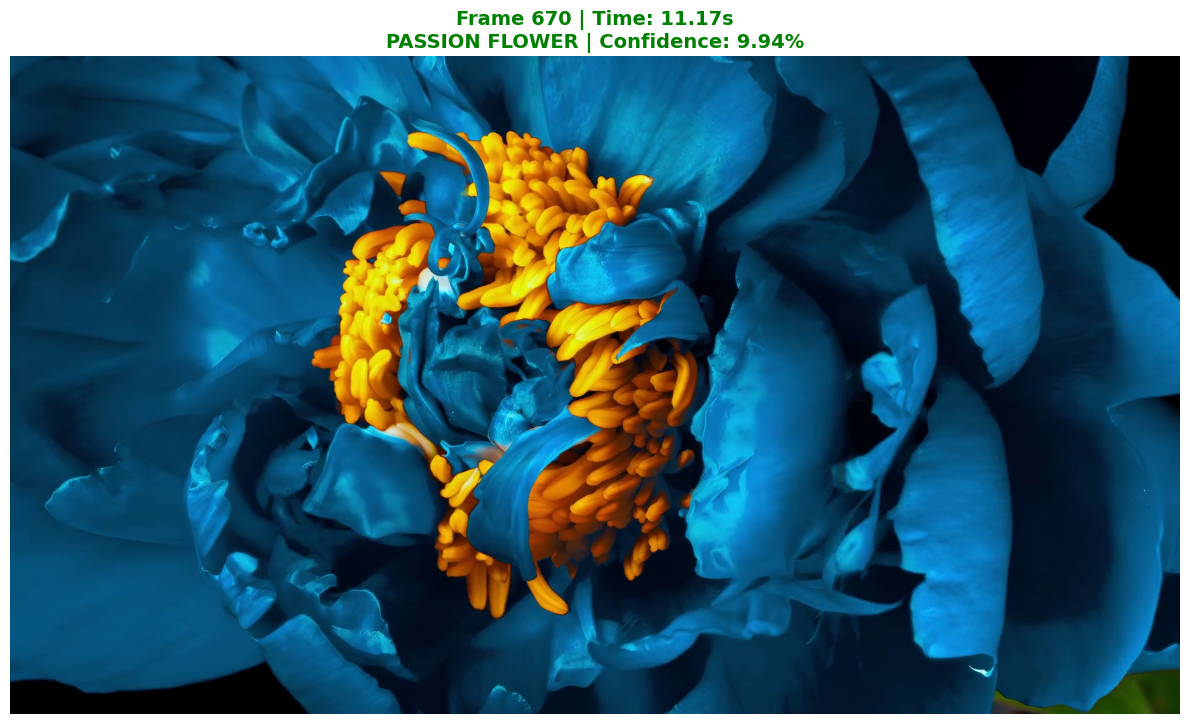

In [ ]:
video_path = video_manager.select_video('video_3')
if video_path:
    results = play_video_with_predictions(video_path, frame_interval=5, display_delay=0.0)